In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists, join, basename, dirname
from glob import glob

import ipywidgets as widgets
from IPython.display import display

import os

%matplotlib inline

from ultralytics import YOLO

import gc

from tqdm import tqdm
from matplotlib.colors import Normalize, ListedColormap

In [28]:
def get_image_mask(model_path: str, image_path: str, image_height: int, image_width: int):

    model = YOLO(model_path)
    result_full_image = model(image_path, verbose=False)

    binary_mask_full_img = np.zeros((image_height, image_width))
    for result in result_full_image:
        mask = result.masks
        if mask != None:
            coordinates = mask.xy
            non_empty_masks = [coords for coords in coordinates if coords.size > 0]

            if non_empty_masks:
                contours = [contour.astype(np.int32).reshape((-1, 1, 2)) for contour in non_empty_masks]
                binary_mask_full_img = cv2.drawContours(binary_mask_full_img, contours, -1, (255), thickness=cv2.FILLED).astype(np.uint8)
    
    return binary_mask_full_img

def get_patches_masks(model_path: str, patches_path: str, patch_height: int, patch_width: int):

    model = YOLO(model_path)
    result_patches = model(patches_path, verbose=False)

    patches_masks = []
    for result_patch in result_patches:
        binary_mask_patch = np.zeros((patch_height,patch_width))
        mask = result_patch.masks
        if mask != None:
            coordinates = mask.xy
            non_empty_masks = [coords for coords in coordinates if coords.size > 0]

            if non_empty_masks:
                contours = [contour.astype(np.int32).reshape((-1, 1, 2)) for contour in non_empty_masks]
                binary_mask_patch = cv2.drawContours(binary_mask_patch, contours, -1, (255), thickness=cv2.FILLED).astype(np.uint8)

        patches_masks.append(binary_mask_patch)

    return patches_masks

def combine_mask_patches(patches_masks: list, n_patches: dict, n_rows_patch: int, n_cols_patch: int, img_shape: tuple):
    reg_patches = patches_masks[:n_patches["reg"]]
    inter_patches = patches_masks[n_patches["reg"]:n_patches["reg"]+n_patches["inter"]]
    hor_patches = patches_masks[n_patches["reg"]+n_patches["inter"]:n_patches["reg"]+n_patches["inter"]+n_patches["hor"]]
    ver_patches = patches_masks[n_patches["reg"]+n_patches["inter"]+n_patches["hor"]:n_patches["reg"]+n_patches["inter"]+n_patches["hor"]+n_patches["ver"]]

    reg_patches_count = 0
    inter_patches_count = 0
    hor_patches_count = 0
    ver_patches_count = 0

    reg_array = np.zeros(img_shape)
    inter_array = np.zeros(img_shape)
    hor_array = np.zeros(img_shape)
    ver_array = np.zeros(img_shape)

    img_height, img_width = img_shape
    img_height_patch, img_width_patch = (
        img_height // n_rows_patch,
        img_width // n_cols_patch,
    )

    for i in range(n_rows_patch):
        for j in range(n_cols_patch):

            x_min_patch, x_max_patch = j * img_width_patch, (j + 1) * img_width_patch
            y_min_patch, y_max_patch = i * img_height_patch, (i + 1) * img_height_patch

            y_half_step = int(0.5 * img_height_patch)
            x_half_step = int(0.5 * img_width_patch)

            reg_array[y_min_patch:y_max_patch,x_min_patch:x_max_patch] = reg_patches[reg_patches_count]
            reg_patches_count += 1

            if i < n_rows_patch - 1 and j < n_cols_patch - 1:

                inter_array[y_min_patch + y_half_step:y_max_patch + y_half_step,x_min_patch + x_half_step:x_max_patch + x_half_step] = inter_patches[inter_patches_count]
                inter_patches_count += 1

            if (i == 0 or i == n_rows_patch - 1) and j < n_cols_patch - 1:

                hor_array[y_min_patch:y_max_patch,x_min_patch + x_half_step:x_max_patch + x_half_step] = hor_patches[hor_patches_count]
                hor_patches_count += 1

            if (j == 0 or j == n_cols_patch - 1) and i < n_rows_patch - 1:

                ver_array[y_min_patch+y_half_step:y_max_patch+y_half_step,x_min_patch:x_max_patch] = ver_patches[ver_patches_count]
                ver_patches_count += 1

    combined_array = np.maximum.reduce([reg_array,inter_array,hor_array,ver_array]).astype(np.uint8)

    return combined_array

def combine_mask_models(masks_model_a: np.array, mask_model_b: np.array):

    return np.maximum(masks_model_a,mask_model_b)

In [29]:
test_paths = glob("data/data_split/ctrst-0-255_srfc-200_prcs-0_seg/test/images/*")
test_full_images = set(basename(img_path).split("_")[0] for img_path in test_paths)

test_paths = glob("data/data_split/ctrst-0-255_srfc-0-200_prcs-0_seg_patch/test/images/*")
test_patches_images = list(set(basename(img_path).split("_")[0] for img_path in test_paths))

In [30]:
list(test_full_images.intersection(test_patches_images))

['005-0405',
 '005-1035',
 '007-0173',
 '008-7429',
 '007-0178',
 '009-3220',
 '008-7425',
 '010-1471',
 '007-0295',
 '008-7524',
 '005-0854',
 '008-2980',
 '008-7515',
 '008-3230',
 '010-1239',
 '005-0707',
 '009-3202',
 '007-0258']

In [31]:
N_ROWS_PATCH = 8
N_COLS_PATCH = 8

PATH_DATASET_PATCH_IMAGES = "data/data_split/ctrst-0-255_srfc-0-200_prcs-0_seg_patch/test/images"
PATH_DATASET_FULL_IMAGES = "data/data_split/ctrst-0-255_srfc-200_prcs-0_seg/test/images"

PATH_MODEL_FULL = "runs/segmentation/yolo11n_ctrst-0-255_srfc-200_prcs-0_seg_epochs-100_imgsz-1520_batch-8/weights/best.pt"
PATH_MODEL_PATCH = "runs/segmentation/yolo11n_ctrst-0-255_srfc-0-200_prcs-0_seg_patch_epochs-100_imgsz-190_batch-8/weights/best.pt"

img_name = '010-1471'

In [49]:
def visualise(img_name: str):

    n_reg_patches = N_ROWS_PATCH * N_COLS_PATCH
    n_inter_patches = (N_ROWS_PATCH - 1) * (N_COLS_PATCH - 1)
    n_hor_patches = 2 * (N_COLS_PATCH - 1)
    n_ver_patches = 2 * (N_ROWS_PATCH - 1)

    img_mask = []
    img = []

    n_patches = {"reg":n_reg_patches,"inter":n_inter_patches,"hor":n_hor_patches,"ver":n_ver_patches}

    path_slices_full_image = glob(join(PATH_DATASET_FULL_IMAGES,img_name + "*.jpg"))

    path_slices_full_image_sorted = [0]*len(path_slices_full_image)
    for img_path in path_slices_full_image:
        slice_idx = basename(img_path).split(".")[0].split("-")[-1]
        path_slices_full_image_sorted[int(slice_idx)] = img_path

    for slice_idx, slice_path in tqdm(enumerate(path_slices_full_image_sorted)):

        path_patches_slice = glob(join(PATH_DATASET_PATCH_IMAGES,basename(slice_path).split(".")[0]+"_*.jpg"))
        path_patches_sorted = [0]*len(path_patches_slice)
        for img_path in path_patches_slice:
            patch_idx = basename(img_path).split(".")[0].split("-")[-2]
            path_patches_sorted[int(patch_idx)-1] = img_path

        full_image = cv2.imread(slice_path, cv2.IMREAD_GRAYSCALE)

        image_height, image_width = full_image.shape
        patch_height, patch_width = image_height // N_ROWS_PATCH, image_width // N_COLS_PATCH

        image_mask = get_image_mask(PATH_MODEL_FULL, slice_path, image_height, image_width)
        patches_masks = get_patches_masks(PATH_MODEL_PATCH, path_patches_sorted, patch_height, patch_width)

        combined_patches_masks = combine_mask_patches(patches_masks, n_patches, N_ROWS_PATCH, N_COLS_PATCH, (image_height, image_width))
        del patches_masks

        final_mask = combine_mask_models(image_mask, combined_patches_masks)
        del image_mask, combined_patches_masks

        img_mask.append(final_mask)
        img.append(full_image)
        
        del path_patches_slice, path_patches_sorted, final_mask, full_image
        gc.collect()

    def display_boxes(start_slice: int, min_contrast: int, max_contrast: int):
        plt.ioff()
        fig, axes = plt.subplots(1, 1, figsize=(20, 10))
        norm = Normalize(vmin=1, vmax=101)
        
        axes.imshow(img[start_slice], cmap="gray", vmin=min_contrast, vmax=max_contrast)
        axes.imshow(np.where(img_mask[start_slice]==0,np.nan,start_slice+1), cmap="viridis", alpha=0.25, norm=norm)
        axes.axis('off')

        plt.tight_layout()
        plt.show() 

    slice_slider = widgets.IntSlider(
        value=0, min=0, max=100, step=1, description='Slice:'
    )

    contrast_min_slider = widgets.IntSlider(
        value=0, min=0, max=254, step=1, description='Min Contrast:'
    )

    contrast_max_slider = widgets.IntSlider(
        value=255, min=1, max=255, step=1, description='Max Contrast:'
    )

    interactive_plot = widgets.interactive(display_boxes, start_slice=slice_slider, min_contrast=contrast_min_slider, max_contrast=contrast_max_slider)

    return interactive_plot, img_mask, img

In [ ]:
interactive_plot, img_mask, img = visualise(img_name)

In [51]:
interactive_plot

interactive(children=(IntSlider(value=0, description='Slice:'), IntSlider(value=0, description='Min Contrast:'…

In [35]:
all_slices = np.array(img_mask)
all_images = np.array(img)
combined_slices  = np.zeros((all_slices.shape[1],all_slices.shape[2]))
combined_images = np.ones((all_slices.shape[1],all_slices.shape[2])) * 255

for i in range(all_slices.shape[0]):
    combined_slices = np.where(all_slices[i] == 255, i+1, combined_slices)
    combined_images = np.where(all_slices[i] == 255, all_images[i], combined_images)

In [36]:
viridis_cmap = plt.cm.viridis
new_colors = viridis_cmap(np.linspace(0, 1, 256))
new_colors[0] = [0, 0, 0, 1]
custom_cmap = ListedColormap(new_colors)
norm = Normalize(vmin=1, vmax=101)

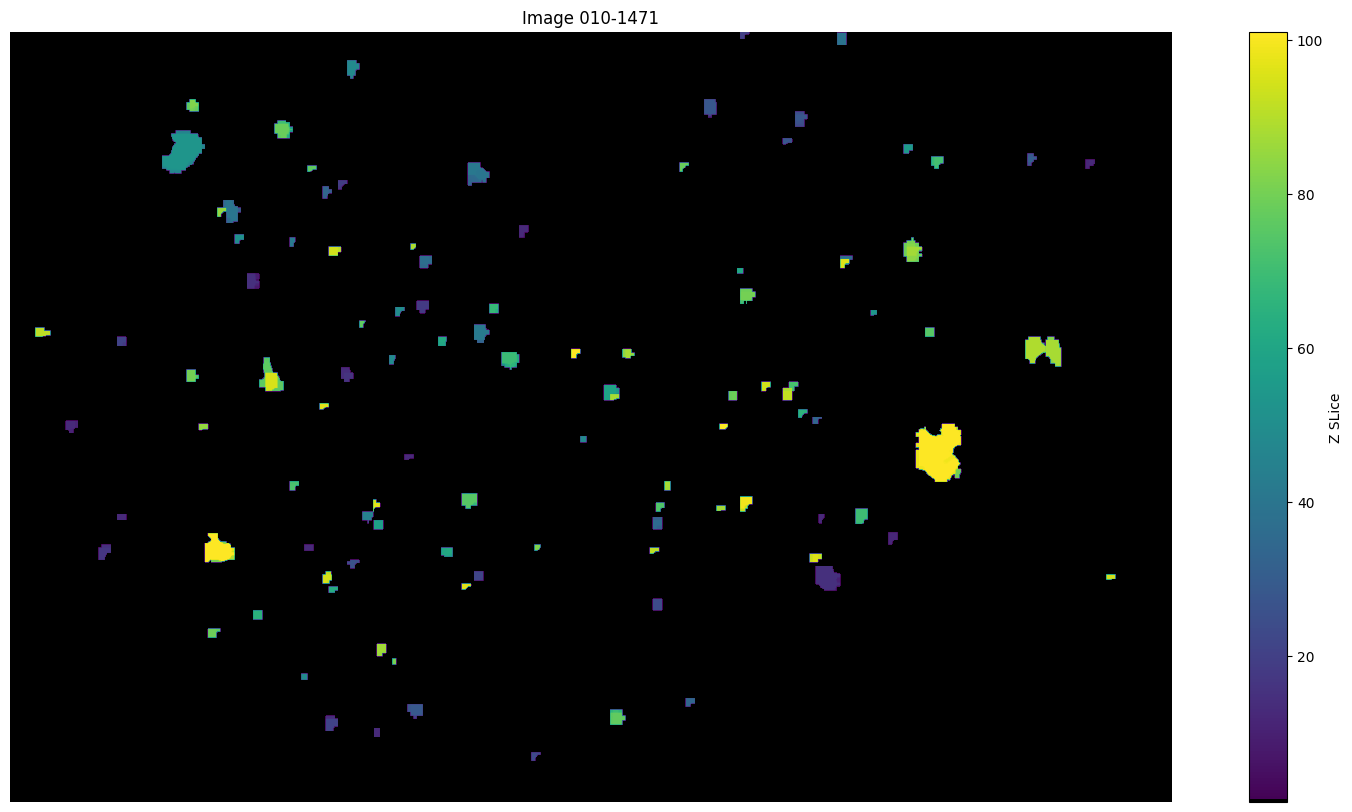

In [37]:
plt.figure(figsize=(20,10))
plt.title(f"Image {img_name}")
plt.imshow(combined_slices, cmap=custom_cmap, norm=norm)
plt.colorbar(label="Z SLice")
plt.axis("off")
plt.show()

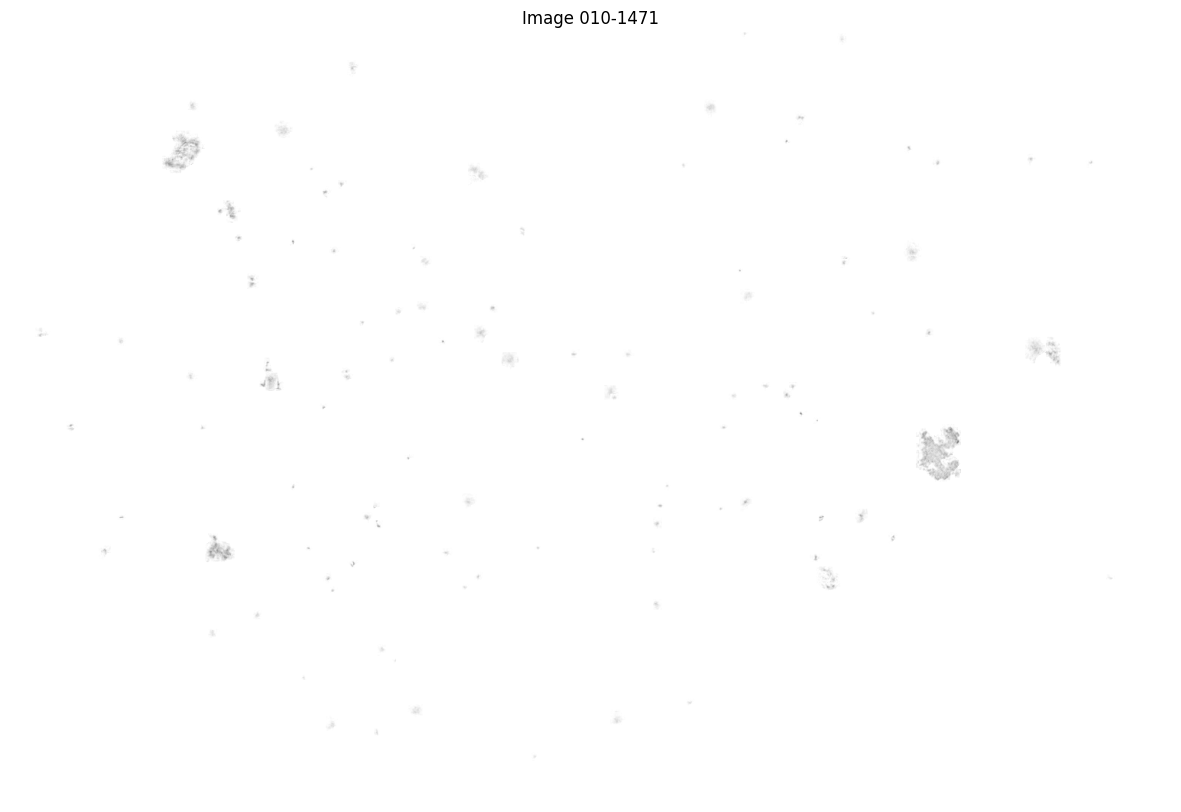

In [45]:
plt.figure(figsize=(20,10))
plt.title(f"Image {img_name}")
plt.imshow(combined_images, cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.show()